# Evaluation - Echo Chamber

The primary goal of this project is to provide users with recommendations that are different from those produced by an ALS recommendation system, but not too different. To evaluate the performance of the augmented, four metrics were developed to evaluate how different the movies recommended by the augmented model are from those recommened by the ALS model.

The <a href='#metric1'>first metric</a> looks a user's Top 100 ALS recommendations (based on predicted user ratings) and the Top 100 recommendations from the user's cluster (based on the cluster centroid's ratings). The proportion of the ALS recommended movies also found in the cluster recommendations should be high. A high proportion indicates that the user's cluster is representative of the user's movie preferences. 

The <a href='#metric2'>second metric</a> looks a user's Top 100 ALS recommendations (based on predicted user ratings) and the top recommendations from the augmented model (based on the cluster centroid's ratings for the two clusters nearest to the user's cluster). The proportion of the ALS recommended movies also found in the augmented model recommendations should be low. A low proportion indicates that the recommendations from the augmented model differ from those produced by the ALS model.

The <a href='#metric3'>third metric</a> utilizes the distance between movies (based on the ALS item factors) to evaluate the extent to which the movies from the augmented model are qualitatively different from the movies from the ALS model. For this metric, the mean squared distance between the Top 100 movies from the ALS model (excluding the distance between a movie and itself) is calculated for each user in the sample. Likewise, the mean squared distance between each of the Top 100 ALS movies and each of the top movies from augmented model is calculated for each user in the sample. The difference between these mean squared distances for the sample are tested using a t-test. A negative and statistically significant t-statistic indicates the mean difference between the two sets of recommendations is greater than the mean difference within the ALS recommendations and, thus, the movies from the augmented model are qualitatively different from the movies from the ALS model.

The <a href='#metric4'>final metric</a> evaluates whether the movies recommended by the augmented model are too qualitatively different from the ALS recommendations. The metric tests the difference between two differences: the difference between ALS and the augmented model and the difference between ALS and recommendations from the two clusters furthest away from the user's cluster. These differences are calculated in the same way as described above for third metric. The difference in differences is tested using a t-test. A positive and statistically significant t-statistic indicates the difference between the ALS recommendations and those from the furthest clusters is greater than the distance between the ALS recommendations and the augmented model's recommendations. A greater distance is evidence that the augmented model recommendations are not too different from the ALS recommendations since the movies recommended by the furthest clusters are more different. 

The performance of the augmented model is evaluated in the cells below by applying the above metrics to a sample of 1000 users from the MovieLens dataset. The links above can be used to skip to a particular metric in Sections 5 - 8. Sections 2 - 4 demonstrate the process for importing, sampling, filtering, and engineering the data for evaluation. 

## Local Code Imports

In [117]:
from src import model as mdl
from src import custom as cm

## Code Imports

In [2]:
import pandas as pd
import numpy as np
from joblib import load
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

# Data

## Import Data Files

In [3]:
user_fac = pd.read_csv('../data/processed/user_factors.csv', index_col='id')

In [5]:
item_fac = pd.read_csv(
    '../data/processed/item_factors_unstacked.csv', index_col='id')

## Build Rankings Matrix

The following cell multiplies the user factors and item factors calculated from the ALS model implementation to get the ALS movie ratings for each user (see the SparkALS.py file in the model folder for the ALS implementation code).

In [8]:
ALS_rankings_matrix = user_fac.to_numpy().dot(item_fac.T.to_numpy())

In [9]:
ALS_rankings_matrix.shape

(243658, 28755)

## Sample Users

To sample users, an index of random values is generated. The index is then used to filter rows from the user factors object (user_fac) and the ALS rankings matrix. The sample is transformed from a numpy array to a dataframe, the columns set to be the movie IDs (take from the item_fac index), and then transposed so that each column represents a user and each row a movie. Lastly, the index is reset making the movieId a column in the dataframe. 

In [10]:
idx = np.random.randint(0, 243658, size=1000)

In [11]:
sample_user_facs = user_fac.to_numpy()[idx, :]

In [12]:
sample = ALS_rankings_matrix[idx, :]

In [13]:
sample_df = pd.DataFrame(sample)

In [15]:
sample_df.columns = item_fac.index

In [17]:
sample_T = sample_df.T

In [19]:
sample_T.reset_index(inplace=True)

## Filter for Most Rated Movies

The ALS and augmented models used in this project only recommend movies that have been rated by more than 50 users. The file most_rated.csv contains the movie ID, title, and genre for these often rated movies. Using the most rated movies, the sample is filtered to include only those movies with more than 50 user reviews. This is done so that the evaluation below is based on the same set of possible movie recommendations as used in the recommendation system. 

In [21]:
most_rated = pd.read_csv(
    '../data/processed/most_rated.csv', index_col='Unnamed: 0')

In [23]:
sample_redx = pd.merge(sample_T, most_rated, how='inner',
                       left_on='id', right_on='movieId')

In [24]:
sample_redx.set_index('id', inplace=True)

In [25]:
sample_redx.drop(['movieId', 'title', 'genres'], axis=1, inplace=True)

# Get ALS Top 100 for Sample

The following cell creates a list of the Top 100 rated movies for each user based on the ALS model. 

In [26]:
als_top_100s = []
for idx, col in enumerate(sample_redx):
    top_100 = sample_redx[col].sort_values(ascending=False).head(100)
    top_100_df = pd.DataFrame(top_100)
    top_100_df.reset_index(inplace=True)
    als_top_100s.append(top_100_df)

# Get Cluster Top 100 for Sample

The augmented model gets recommendations from the two clusters nearest to the user's cluster. The following cells predict the cluster of each user in the sample, gets creates a dataframe with the movie ratings for each cluster, and generates a list of the Top 100 movies recommendations for each user in the sample from the user's predicted cluster. 

## Predict Users' Clusters

In [27]:
gbc = load('../models/fifp_classification.joblib')

In [28]:
preds = gbc.predict(sample_user_facs)

## Get Cluster Centroid Ratings

In [29]:
centroids = pd.read_csv(
    '../data/processed/centroids.csv', index_col='Unnamed: 0')
centroid_ratings_T_df = cm.get_centroid_ratings(centroids, item_fac)

In [30]:
centroid_ratings_T_df.reset_index(inplace=True)

In [31]:
centroid_ratings_redx = pd.merge(
    centroid_ratings_T_df, most_rated, how='inner', left_on='id', right_on='movieId')

In [32]:
centroid_ratings_redx.set_index('id', inplace=True)

In [33]:
centroid_ratings_redx.drop(
    ['movieId', 'title', 'genres'], axis=1, inplace=True)

## Get Cluster Top 100

In [36]:
cluster_top_100s = []
for cluster in preds:
    top_100 = centroid_ratings_redx[cluster].sort_values(
        ascending=False).head(100)
    top_100_df = pd.DataFrame(top_100)
    top_100_df.reset_index(inplace=True)
    cluster_top_100s.append(top_100_df)

<a id='metric1'></a>

# Evaluation Metric 1: Proportion of Top 100 Movies Shared between the ALS recommendations and the User's Cluster Centroid

The first metric evaluates the similarity between the top 100 ALS recommendations (based on predicted user ratings) and those generated by the user's cluster (based on the cluster centroid's ratings). The proportion of the ALS recommended movies also found in the cluster recommendations should be high indicating the user's cluster is representative of the user's movie preferences.

In [153]:
proportions1 = []
for i in range(len(cluster_top_100s)):
    als_set = set(als_top_100s[i].iloc[:, 0])
    cluster_set = set(cluster_top_100s[i].iloc[:, 0])
    intersection = als_set.intersection(cluster_set)
    n_in_common = len(intersection)
    proportion_in_common = (n_in_common/100)
    proportions1.append(proportion_in_common)

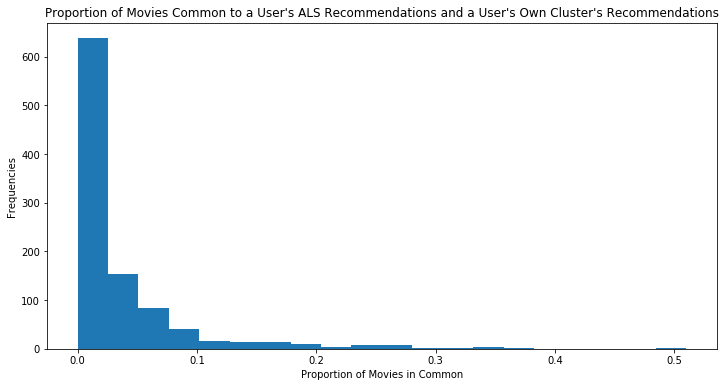

In [158]:
plt.figure(figsize=(12, 6))
plt.title('Proportion of Movies Common to a User\'s ALS Recommendations and a User\'s Own Cluster\'s Recommendations')
plt.ylabel('Frequencies')
plt.xlabel('Proportion of Movies in Common')
plt.hist(proportions1, bins=20)
plt.show;
plt.savefig('../reports/figures/Metric1.png')

<a id='metric2'></a>

# Evaluation Metric 2: Proportion of Top 100 Movies Shared between the ALS and Augmented Recommendations

The second metric evaluates the similarity between the top 100 ALS recommendations (based on predicted user ratings) and the top recommendations from the augmented model. The proportion of the ALS recommended movies also found in the augmented model recommendations should be low indicating the recommendations from the augmented model differ from those produced by the ALS model.

In [39]:
cluster_distances = pd.read_csv(
    '../data/processed/cluster_distances_df.csv', index_col='Unnamed: 0')

In [40]:
cluster_distances.head()

,0,1,2,3,4,5,6,7,8
0,0.000000,8.798096,9.716017,7.041225,6.007564,10.984834,5.646137,6.316699,6.183063
1,8.798096,0.000000,5.956857,6.540400,8.858469,4.575128,4.660669,4.302251,4.401584
2,9.716017,5.956857,0.000000,7.768660,6.161390,9.719417,5.783137,8.817718,5.600428
3,7.041225,6.540400,7.768660,0.000000,8.586475,7.407208,6.431559,6.280426,6.763831
4,6.007564,8.858469,6.161390,8.586475,0.000000,12.469241,6.062674,8.974924,5.407681


In [41]:
cm.get_nearest_clusters(cluster_distances, '8')

array([6, 1])

In [155]:
proportions2 = []
for i in range(len(cluster_top_100s)):
    j = preds[i]
    nearest_clusters = cm.get_nearest_clusters(
        cluster_distances, '{}'.format(j))
    cluster1 = nearest_clusters[0]
    cluster2 = nearest_clusters[1]
    als_set = set(als_top_100s[i].iloc[:, 0])
    cluster1_set = set(cluster_top_100s[cluster1].iloc[:, 0])
    cluster2_set = set(cluster_top_100s[cluster2].iloc[:, 0])
    cluster_full = cluster1_set.union(cluster2_set)
    intersection = als_set.intersection(cluster_full)
    n_in_common = len(intersection)
    proportion_in_common = (n_in_common/100)
    proportions2.append(proportion_in_common)

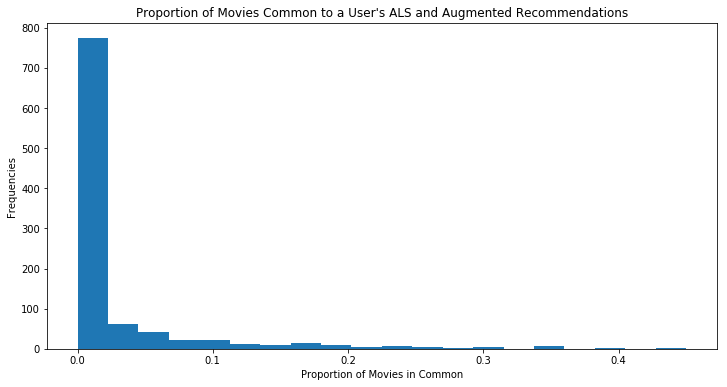

In [157]:
plt.figure(figsize=(12, 6))
plt.title('Proportion of Movies Common to a User\'s ALS and Augmented Recommendations')
plt.ylabel('Frequencies')
plt.xlabel('Proportion of Movies in Common')
plt.hist(proportions2, bins=20)
plt.show;
plt.savefig('../reports/figures/Metric2.png')

<a id='metric3'></a>

# Evaluation Metric 3: Distances Between ALS Recommended Movies and Nearest Cluster Recommended Movies

In addition to recommending a different set of movies than the ALS model, the goal of the augmented model is to recommend movies that are qualitatively more diverse. To test for differences in the qualities of movie recommended by each model, the third evaluation metric assesses the distances between movies. For each user, the mean squared distance between movies recommended by the ALS model is calculated. Then, the mean squared distance between movies recommended by ALS model and movies recommended by the augmented model is calculated for each user. For the sample, the difference in the two mean squared distance calculations is tested using a t-test. A negative and statistically significant t-statistic indicates the mean difference between the two sets of recommendations is greater than the mean difference within the ALS recommendations and, thus, the movies from the augmented model are qualitatively different from the movies from the ALS model.

In [44]:
movie_distances = cm.get_cluster_distances(item_fac)

In [75]:
movie_distances.columns = item_fac.index

In [77]:
movie_distances.index = item_fac.index

In [120]:
nearest_clusters_top = []
for i in range(len(cluster_top_100s)):
    j = preds[i]
    nearest_clusters = cm.get_nearest_clusters(
        cluster_distances, '{}'.format(j))
    cluster1 = nearest_clusters[0]
    cluster2 = nearest_clusters[1]
    cluster1_set = set(cluster_top_100s[cluster1].iloc[:, 0])
    cluster2_set = set(cluster_top_100s[cluster2].iloc[:, 0])
    cluster_full_set = cluster1_set.union(cluster2_set)
    cluster_full_list = list(cluster_full_set)
    nearest_clusters_top.append(cluster_full_list)

In [114]:
MSS_distances_within = []
for i in range(len(als_top_100s)):
    within_distances = []
    for j in als_top_100s[i].iloc[:, 0]:
        for k in als_top_100s[i].iloc[:, 0]:
            if j == k:
                pass
            else:
                within_distances.append(movie_distances[j][k])
    sq_within_distances = [x**2 for x in within_distances]
    MSS_distances = np.mean(sq_within_distances)
    MSS_distances_within.append(MSS_distances)

In [127]:
MSS_distances_between = []
for i in range(len(als_top_100s)):
    between_distances = []
    for j in als_top_100s[i].iloc[:, 0]:
        for k in nearest_clusters_top[i]:
            between_distances.append(movie_distances[j][k])
    sq_between_distances = [x**2 for x in between_distances]
    MSS_distances = np.mean(sq_between_distances)
    MSS_distances_between.append(MSS_distances)

In [128]:
stats.ttest_ind(MSS_distances_within, MSS_distances_between, equal_var=False)

Ttest_indResult(statistic=-66.19551095638982, pvalue=0.0)

<a id='metric4'></a>

# Evaluation: Difference in Distances Between ALS Recommended Movies and Nearest Cluster Recommended Movies and the Distances Between ALS Recommended Movies and Furthest Cluster Recommended Movies

The goal of the augmented model is to recommend movies that are qualitatively different, but not too different, from those provided by the ALS model. Recommendations that are too different will be ignored or, worse, could result in the user no longer using the recommendation service. 

To test that the recommendations provided by the augmented model are not too different for the ALS recommendation, metric 4 compares the differences between the ALS and augmented recommendations to the difference between the ALS recommendations and those provided by the two clusters furthest from the user's cluster. Recommendations from the furthest clusters should be more different than recommendations from the nearest clusters (i.e., the augmented model). For the sample, the difference in differences is tested using a t-test. A positive and statistically significant t-statistic indicates the difference between the ALS recommendations and the furthest cluster recommendations is greater than the difference between the ALS recommendations and the augmented recommendations. If the difference is positive and statitically significant, then the augmented recommendations are not as different as the recommendations from the furthest clusters and therefore are not too different from the ALS recommendations. 

In [129]:
furthest_clusters_top = []
for i in range(len(cluster_top_100s)):
    j = preds[i]
    nearest_clusters = cm.get_furthest_clusters(
        cluster_distances, '{}'.format(j))
    cluster1 = nearest_clusters[0]
    cluster2 = nearest_clusters[1]
    cluster1_set = set(cluster_top_100s[cluster1].iloc[:, 0])
    cluster2_set = set(cluster_top_100s[cluster2].iloc[:, 0])
    cluster_full_set = cluster1_set.union(cluster2_set)
    cluster_full_list = list(cluster_full_set)
    furthest_clusters_top.append(cluster_full_list)

In [132]:
MSS_distances_between_furthest = []
for i in range(len(als_top_100s)):
    within_distances = []
    for j in als_top_100s[i].iloc[:, 0]:
        for k in furthest_clusters_top[i]:
            within_distances.append(movie_distances[j][k])
    sq_within_distances = [x**2 for x in within_distances]
    MSS_distances = np.mean(sq_within_distances)
    MSS_distances_between_furthest.append(MSS_distances)

In [139]:
within_between_differences = np.subtract(
    MSS_distances_between, MSS_distances_within)
within_furthest_differences = np.subtract(
    MSS_distances_between_furthest, MSS_distances_within)

In [141]:
stats.ttest_ind(within_furthest_differences,
                within_between_differences, equal_var=False)

Ttest_indResult(statistic=5.516741793081464, pvalue=3.907336572476676e-08)